In [21]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)

In [24]:
gpu()


<tf.Tensor: shape=(), dtype=float32, numpy=898.44604>

In [0]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARMA
import warnings
from itertools import product
from datetime import datetime, timedelta
import calendar

In [0]:
warnings.filterwarnings('ignore')
# 数据加载
df = pd.read_excel('Prices.xlsx')
df = df[['时间(年-月)', '供给(元/㎡)']]

In [0]:
df.rename(columns = {"时间(年-月)": "Timestamp",'供给(元/㎡)':"Price"},inplace=True)

In [0]:
# 将时间作为df的索引
df.Timestamp = pd.to_datetime(df.Timestamp)
df.index = df.Timestamp

In [73]:
# 数据探索
print(df.head())

            Timestamp  Price
Timestamp                   
2019-03-01 2019-03-01  65253
2019-02-01 2019-02-01  65473
2019-01-01 2019-01-01  64663
2018-12-01 2018-12-01  63405
2018-11-01 2018-11-01  62298


In [74]:
# 按照月，季度，年来统计
df_month = df.resample('M').mean()
df_Q = df.resample('Q-DEC').mean()
df_year = df.resample('A-DEC').mean()
print(df_month)
#print(df_Q)
#print(df_year)

            Price
Timestamp        
2014-03-31  40261
2014-04-30  38537
2014-05-31  38573
2014-06-30  37605
2014-07-31  37271
...           ...
2018-11-30  62298
2018-12-31  63405
2019-01-31  64663
2019-02-28  65473
2019-03-31  65253

[61 rows x 1 columns]


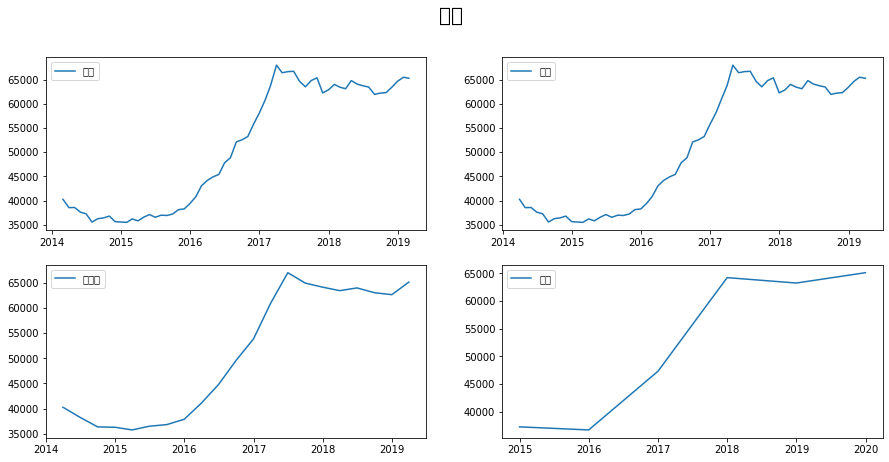

In [75]:
# 按照天，月，季度，年来显示房价的走势
fig = plt.figure(figsize=[15, 7])
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.suptitle('房价', fontsize=20)
plt.subplot(221)
plt.plot(df.Price, '-', label='按天')
plt.legend()
plt.subplot(222)
plt.plot(df_month.Price, '-', label='按月')
plt.legend()
plt.subplot(223)
plt.plot(df_Q.Price, '-', label='按季度')
plt.legend()
plt.subplot(224)
plt.plot(df_year.Price, '-', label='按年')
plt.legend()
plt.show()

参数错误: (0, 2)
最优模型:                                ARMA Model Results                              
Dep. Variable:                  Price   No. Observations:                   61
Model:                     ARMA(2, 0)   Log Likelihood                -525.867
Method:                       css-mle   S.D. of innovations           1291.839
Date:                Wed, 15 Apr 2020   AIC                           1059.733
Time:                        08:35:23   BIC                           1068.177
Sample:                    03-31-2014   HQIC                          1063.043
                         - 03-31-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.277e+04   1.02e+04      5.185      0.000    3.28e+04    7.27e+04
ar.L1.Price     1.3683      0.119     11.504      0.000       1.135       1.601
ar.L2.Price    -0.3774      

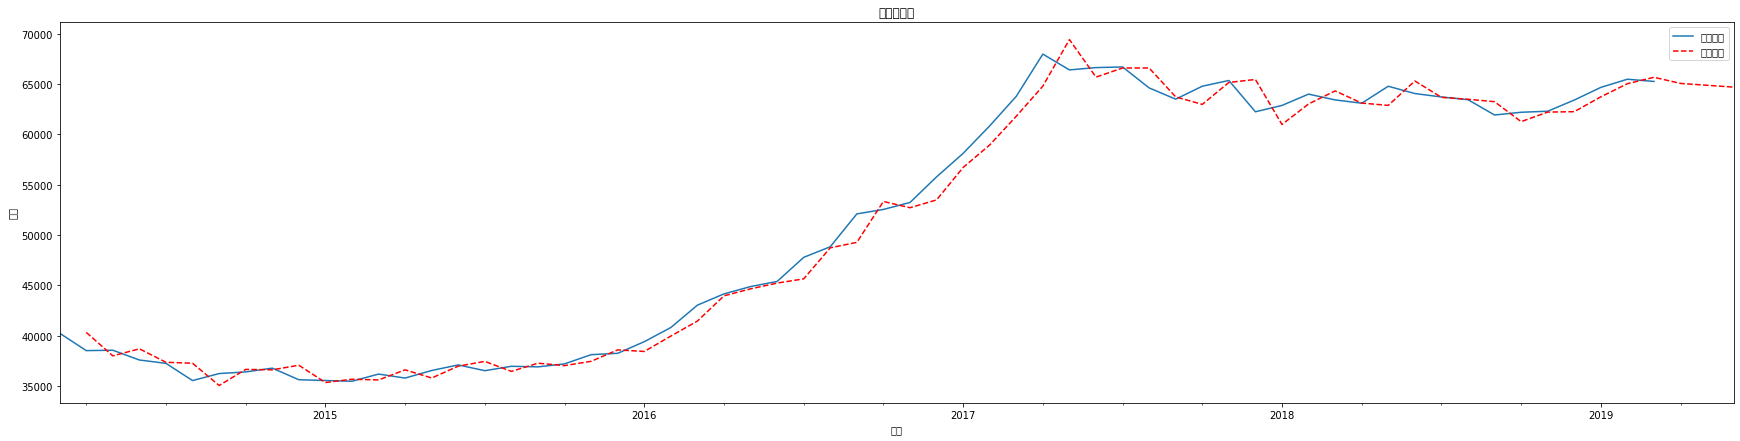

In [76]:
# 设置参数范围
ps = range(0, 3)
qs = range(0, 3)
parameters = product(ps, qs)
parameters_list = list(parameters)
# 寻找最优ARMA模型参数，即best_aic最小
results = []
best_aic = float("inf") # 正无穷
for param in parameters_list:
    try:
        model = ARMA(df_month.Price,order=(param[0], param[1])).fit()
    except ValueError:
        print('参数错误:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
# 输出最优模型
print('最优模型: ', best_model.summary())

# 设置future_month，需要预测的时间date_list
df_month2 = df_month[['Price']]
future_month = 3
last_month = pd.to_datetime(df_month2.index[len(df_month2)-1])
#print(last_month)
date_list = []
for i in range(future_month):
    # 计算下个月有多少天
    year = last_month.year
    month = last_month.month
    if month == 12:
        month = 1
        year = year+1
    else:
        month = month + 1
    next_month_days = calendar.monthrange(year, month)[1]
    #print(next_month_days)
    last_month = last_month + timedelta(days=next_month_days)
    date_list.append(last_month)
print('date_list=', date_list)

# 添加未来要预测的3个月
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = best_model.predict(start=0, end=len(df_month2))
# 第一个元素不正确，设置为NaN
df_month2['forecast'][0] = np.NaN
print(df_month2)

# 房价预测结果显示
plt.figure(figsize=(30,7))
df_month2.Price.plot(label='实际房价')
df_month2.forecast.plot(color='r', ls='--', label='预测房价')
plt.legend()
plt.title('房价（月）')
plt.xlabel('时间')
plt.ylabel('房价')
plt.show()